In [13]:
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import numpy as np
import math
from nltk import bigrams
from utility_funcs import *
import sys
import pandas as pd
import time
from datetime import datetime, timedelta

%matplotlib inline

class Logger(object):
    def __init__(self,name):
        self.terminal = sys.stdout
        self.log = open("../data/clean_v1/network_output/relation_freq/"+"rel_freq_"+name+".txt", "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)  
        
    def flush(self):
        pass


time_pos = 1 
tweet_raw_pos = 11
tweet_clean_pos = 13
conf_pos = 15
arg1_pos = 16
rel_pos = 17
arg2_pos = 18
polarity_pos = 19
subjectivity_pos = 20


REMOVE_STOPWORDS = False#True

good_stop_words = set(('not'))
cachedStopWords = set(stopwords.words("english"))
cachedStopWords = cachedStopWords - good_stop_words 
connected_entities = defaultdict(list)
bow = [] #bag of words
bow_to_ind = {}

network = []
net_arg1_pos, net_rel_pos, net_arg2_pos, net_sent_pos = 4,5,6,7
tknzr = TweetTokenizer()

def removeStopWords(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text


def readFile_pandas(fileInput,delim):
    ff = open(fileInput)
    h = ff.readline()
    header_orig = h.split(delim)
    df = pd.read_csv(fileInput,delimiter=delim, header=0)#names=header_orig)
    #print df.tweet_id[0:10]
    df['tweet_posted_time'] = df['tweet_posted_time'].apply(lambda x: datetime.strptime(x.split('.')[0], \
                                                                                        '%Y-%m-%dT%H:%M:%S'))
    selected_columns = ['tweet_posted_time', 'tweet_text', 'main_tweet', 'ollie_conf', \
            'ollie_arg1', 'ollie_rel', 'ollie_arg2', 'clean_tweet_polarity','clean_tweet_subjectivity']
    df_selected = df[[i for i in df.columns if i in selected_columns]]
    print "df_selected values - 1"
    #df_selected.values_counts()
    print len(df_selected.index)
    df_selected = df_selected.dropna(how = 'any')
    print "df_selected values - 2 "    
    print len(df_selected.index)
    #print " selected dataframe - index 0 : ", df_selected.iloc[0]
    return df_selected

def filter_by_time(df,start_time,end_time):
    filtered_df = df[(df['tweet_posted_time'] >= start_time) & (df['tweet_posted_time'] <= end_time)]
    return filtered_df

def filter_by_sentiment(df,thr):
    filtered_df = df[(df['clean_tweet_polarity'] >= thr) | (df['clean_tweet_polarity'] <= -1*thr)]
    return filtered_df

def df_to_network(df):
    return df.values.tolist()
    

def readFile(fileInput,delim):
    with open(fileInput,'rb') as f:
        for ind,line in enumerate(f):
            if ind==0:
                continue
            print ind, line
            line = line.split(delim)
            print len(line)
            arg1 = line[arg1_pos]
            rel = line[rel_pos]
            arg2 = line[arg2_pos]
            polarity = line[polarity_pos]
            #remove stop words:
            if REMOVE_STOPWORDS == True:
                arg1 = removeStopWords(arg1)
                rel = removeStopWords(rel)
                arg2 = removeStopWords(arg2)
            # removing ' and "
            rel = rel.replace('"','')
            rel = rel.replace("'",'')
            rel = ' '.join(rel.split())

            network.append([arg1]+[rel]+[arg2]+[polarity])

            #if arg1 not in entity:
            #    entity[line[arg1_pos]][line[arg2_pos]] = line[rel_pos])
            #arg1s.append(line[arg1_pos])
            #rels.append(line[rel_pos])
            #arg2s.append(line[arg2_pos])

    

def hasKeyword_str(myStr,keywords):
    for k in keywords:
        if k in myStr:
            return True
    return False


def hasKeyword_tuple_directed(myTuple,arg1_keywords,arg2_keywords):
    arg1 = myTuple[net_arg1_pos]
    rel = myTuple[net_rel_pos]
    arg2 = myTuple[net_arg2_pos]
    if hasKeyword_str(arg1,arg1_keywords):
        if hasKeyword_str(arg2,arg2_keywords):
            return True
    return False


def print_words_freq(entityNames):
    res = []
    print entityNames
    for c in connected_entities:
        if c in entityNames:
            #print connected_entities[c]
            print c
            for ind,val in enumerate(connected_entities[c]):
                if val != 0:
                    res.append((bow[ind],val))
    #print res
    return res


def get_freq(ent1_ent2,top_num,option="unigram"):
    cnt = Counter()
    sent = defaultdict(int)
    for n in ent1_ent2:
        rel = n[net_rel_pos]
        rel = rel.lower()
        if option == "unigram":
            tokens = rel.split(' ')
            ###tokens = tknzr.tokenize(rel)
        if option == "bigram":
            rel = rel.split(' ')
            tokens = list(bigrams(rel))
        if option == "whole_rel":
            cnt[rel] += 1
            sent[rel] += float(n[net_sent_pos])
            continue

        for tok in tokens:
            cnt[tok] += 1
            sent[tok] += float(n[net_sent_pos])
    print "top relations - option : ", option
    cnt_common = cnt.most_common(top_num)
    #print cnt_common
    res = []    
    for k,v in cnt_common:#.iteritems():
        print " top relation: ", k, " - frequency: " , v, " - sum sentiment: ", sent[k], " - avg sentiment: " , float(sent[k]/v)
        r = []
        r = r + [k,v,sent[k],float(sent[k]/v)]
        res.append(r)
    return res

def create_word_vector(entityName,adjEntities):
    ind = 0
    # extract the bag of words 
    for n in network:
        if entityName in n[net_arg1_pos]:
            ##rel_words = n[1].lower().split(' ')
            rel_words = tknzr.tokenize(n[net_rel_pos])
            for w in rel_words:
                if w not in bow:
                    bow.append(w)
                    bow_to_ind[w]=ind
                    ind += 1

    print "number of words between "+ entityName + " and the other entities : " + str(len(bow))
    for n in network:
        if entityName in n[net_arg1_pos]:
            if n[net_arg2_pos] not in connected_entities:
                bow_arr = [0 for x in range(len(bow))]
                connected_entities[n[net_arg2_pos]] = bow_arr
            ##rel_words = n[1].lower().split(' ') 
            rel_words = tknzr.tokenize(n[net_rel_pos])
            for w in rel_words:
                connected_entities[n[net_arg2_pos]][bow_to_ind[w]] += 1
    #print "len cnt entities: ", len(connected_entities)
    #print connected_entities["early 2016\r\n"]
    #normalizing the vectors
    for c in connected_entities:
        cnt_ent_bow = connected_entities[c]
        bow_sum = 0
        #word = c.lower()
        #word = word.split(' ')
        for it_bow in cnt_ent_bow:
            #print it_bow
            bow_sum += it_bow
        for it_bow in cnt_ent_bow:
            if bow_sum != 0:
                it_bow /= float(bow_sum) #normalizing the bow
    
    sim_res = []
    for c in connected_entities:
        #if "Barclays" in c:
        #    print c
        if c.strip() in adjEntities:
            fix_bow = connected_entities[c]
            print "here"
            for c2 in connected_entities:
                if c2 not in adjEntities:
                    sim = 1 - spatial.distance.cosine(fix_bow, connected_entities[c2])
                    if math.isnan(sim):
                        sim = 0
                    #sim1 = cosine_similarity(fix_bow, connected_entities[c2])
                    #if sim != sim1:
                    #    print "not equal ", sim , " and ", sim1
                    sim_res.append((c2,sim))

    return sim_res


def get_top_rels(entityNames,top_num): 
    ent1Name, ent2Name = entityNames.split('_')[0], entityNames.split('_')[1]
    ent1_ent2 = []
    ent2_ent1 = []
    #key1s, key2s = setKeywords(entityNames)
    key1s = get_versions(ent1Name)
    key2s = get_versions(ent2Name)
    #print key1s, key2s
    #cnt_tmp = 0
    for n in network:
        if hasKeyword_tuple_directed(n,key1s,key2s):
            ent1_ent2.append(n)
        if hasKeyword_tuple_directed(n,key2s,key1s):
            ent2_ent1.append(n)
            #if cnt_tmp < 10:
            #    print n
            #    cnt_tmp += 1


    print ent1Name, " ", ent2Name , len(ent1_ent2)
    #ent1_ent2_rels = [x[1] for x in ent1_ent2]
    freq_option = "unigram"
    ent12_unigram = get_freq(ent1_ent2,top_num,freq_option)
    ent12_bigram = get_freq(ent1_ent2,top_num,"bigram")
    ent12_wholeRel = get_freq(ent1_ent2,top_num,"whole_rel")
    #get_words_freq(ent1_ent2_rels,15)
    #get_bigrams_freq(ent1_ent2_rels,15)

    print ent2Name , " ", ent1Name , len(ent2_ent1)

    #ent2_ent1_rels = [x[1] for x in ent2_ent1]
    #for ii in ent2_ent1:
    #    if "use" in ii[1]:
    #        print ii[0]," -- ",ii[1], " -- ", ii[2]

    freq_option = "unigram"
    ent21_unigram = get_freq(ent2_ent1,top_num,freq_option)
    ent21_bigram = get_freq(ent2_ent1,top_num,"bigram")
    ent21_wholeRel = get_freq(ent2_ent1,top_num,"whole_rel")
    #get_words_freq(ent2_ent1_rels,15)
    #get_bigrams_freq(ent2_ent1_rels,15)
    
    return ent12_unigram, ent12_bigram ,ent12_wholeRel, ent21_unigram, ent21_bigram, ent21_wholeRel



def get_similar_entities(entityNames):
    #entityNames = "Apple_Barclays"
    entName1, entName2 = entityNames.split('_')[0], entityNames.split('_')[1]

    entName1 = "ApplePay"
    entName2 = "Barclays"
    ent1_versions, ent2_versions = get_versions(entName1), get_versions(entName2)
    
    entNames = entName1 + "_" + entName2

    #versions_type =  "_uniqueVersions"
    versions_type =  "_variousVersions"


    nameExt = entNames + versions_type
    fileOutput = "../results/from_cleaned_tweets/rel_similarity_" +nameExt+".txt"
    fileOutput_bow = "../results/from_cleaned_tweets/rel_similarity_"+nameExt+"_bow.txt"
    #fileInput = "../data/from_raw_tweets/ollie_tabular_output.txt"


    #getNetwork(arg

    #sim_res = create_word_vector("Apple Pay",["Barclays"])
    sim_res = create_word_vector(entName1,ent2_versions)
    #sim_res = create_word_vector("Barclays",["Samsung Pay"])
    #sim_res = create_word_vector("Barclays",[""])

    #sim_res = create_word_vector("Apple Pay",ent2_versions)
    sim_res.sort(key=lambda tup:tup[1],  reverse=True)
    
    saveToFile(fileOutput,sim_res,delim='\t')

    for s in sim_res:
        print s
    #print e

'''
def create_gephi_data(option):
    gephi_nodes = {}
    gephi_edges = {}
    nodes = 
    for n in network:
        if n[0] in gephi_nodes:
            if n[2] in gephi_nodes:
                gephi_edges
'''


#def main():
fileInput = "../data/clean_v1/output/ollie_tabular_output_test.csv"
df_raw = readFile_pandas(fileInput,delim=',')    
print "Data loading is done. "
start_time = '2015-07-12'
end_time = '2015-10-16'


#print "Analysis on data gathered between " + start_time + " and " + end_time
df = filter_by_time(df_raw.copy(),start_time,end_time)

#df = df_raw
#df = filter_by_sentiment(df.copy(),0.5)
print "Filtering is done. "
network = df_to_network(df.copy())
#print df.tweet_posted_time

#return df
entityNames = "ApplePay_Barclays"


#entityNames = "Guess_ApplePay"

ent1Name, ent2Name = entityNames.split('_')[0], entityNames.split('_')[1]
#sys.stdout = Logger(entityNames)
#get_similar_entities(entityNames)
ent12_unigram, ent12_bigram ,ent12_wholeRel, ent21_unigram, ent21_bigram, ent21_wholeRel = get_top_rels(entityNames,20)

'''
print entityNames,":\n", ent12_unigram
print entityNames,":\n", ent12_bigram
print entityNames,":\n", ent12_wholeRel
print ent2Name+"_" + ent1Name,":\n", ent21_unigram
print ent2Name+"_" + ent1Name,":\n", ent21_bigram
print ent2Name+"_" + ent1Name,":\n", ent21_wholeRel
'''

#if __name__ == "__main__":
#main()


df_selected values - 1
632920
df_selected values - 2 
632189
Data loading is done. 
Filtering is done. 
ApplePay   Barclays 1340
top relations - option :  unigram
 top relation:  be  - frequency:  668  - sum sentiment:  25.905762987  - avg sentiment:  0.0387810823159
 top relation:  launches  - frequency:  588  - sum sentiment:  10.35  - avg sentiment:  0.0176020408163
 top relation:  as  - frequency:  575  - sum sentiment:  10.35  - avg sentiment:  0.018
 top relation:  to  - frequency:  456  - sum sentiment:  39.0882575758  - avg sentiment:  0.0857198631047
 top relation:  live  - frequency:  316  - sum sentiment:  43.071969697  - avg sentiment:  0.136303701573
 top relation:  goes  - frequency:  314  - sum sentiment:  42.5454545455  - avg sentiment:  0.13549507817
 top relation:  coming  - frequency:  268  - sum sentiment:  8.92207792208  - avg sentiment:  0.0332913355301
 top relation:  in  - frequency:  183  - sum sentiment:  23.7628787879  - avg sentiment:  0.129851796655
 top re

'\nprint entityNames,":\n", ent12_unigram\nprint entityNames,":\n", ent12_bigram\nprint entityNames,":\n", ent12_wholeRel\nprint ent2Name+"_" + ent1Name,":\n", ent21_unigram\nprint ent2Name+"_" + ent1Name,":\n", ent21_bigram\nprint ent2Name+"_" + ent1Name,":\n", ent21_wholeRel\n'

In [ ]:
'''
fileInput = "../data/clean_v1/output/ollie_tabular_output_test.csv"
df_raw = readFile_pandas(fileInput,delim=',')    
print " done. "
df = filter_by_time(df_raw.copy(),'2015-07-01','2015-07-03')

corpus = df['main_tweet'].values
#print type(corpus.values)

print corpus[0]

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)

X = vectorizer.fit_transform(corpus)

X.toarray()
X.shape

vectorizer.get_feature_names()
'''

In [ ]:
ent1 = "ApplePay"
ent2 = "Barclays"
df_raw = readFile_pandas(fileInput,delim=',')    
print "Data loading is done. "
#df = filter_by_time(df_raw.copy(),'2015-10-06','2015-10-10')
df = df_raw

In [ ]:
'''
ent1 = "ApplePay"
ent2 = "Barclays"
df2 = readFile_pandas(fileInput,delim=',') 
df_ent1_ent2 = df2[np.logical_and(df2.ollie_arg1==ent1, df2.ollie_arg2==ent2, df2.ollie_rel=="wo n't get")]
'''

In [ ]:
df_ent1_ent2 = df[np.logical_and(df.ollie_arg1==ent1, df.ollie_arg2==ent2)]
print len(df_ent1_ent2.index)
net_ent1_ent2 = df_to_network(df_ent1_ent2)
print net_ent1_ent2[0]

In [ ]:
res = get_freq(net_ent1_ent2,1,"whole_rel")
print "res:", res, "tamamm."

In [12]:
########## TIME WINDOW
fileInput = "../data/clean_v1/output/ollie_tabular_output_test.csv"
df_raw = readFile_pandas(fileInput,delim=',')    
print "Data loading is done. "
start_time = '2015-07-20'
end_time = '2015-10-05'


#print "Analysis on data gathered between " + start_time + " and " + end_time
df = filter_by_time(df_raw.copy(),start_time,end_time)
#df = filter_by_sentiment(df.copy(),0.5)
print "Filtering is done. "
network = df_to_network(df.copy())

entityNames = "HSBC_ApplePay"


ent1Name, ent2Name = entityNames.split('_')[0], entityNames.split('_')[1]
ent12_unigram, ent12_bigram ,ent12_wholeRel, ent21_unigram, ent21_bigram, ent21_wholeRel = get_top_rels(entityNames,20)

print "salam"
res = ent12_bigram
print entityNames,":\n", ent12_unigram
print entityNames,":\n", ent12_bigram
print entityNames,":\n", ent12_wholeRel
print ent2Name+"_" + ent1Name,":\n", ent21_unigram
print ent2Name+"_" + ent1Name,":\n", ent21_bigram
print ent2Name+"_" + ent1Name,":\n", ent21_wholeRel

df_selected values - 1
632920
df_selected values - 2 
632189
Data loading is done. 
Filtering is done. 
HSBC   ApplePay 668
top relations - option :  unigram
 top relation:  support  - frequency:  154  - sum sentiment:  10.4958333333  - avg sentiment:  0.0681547619048
 top relation:  will  - frequency:  142  - sum sentiment:  8.4725  - avg sentiment:  0.0596654929577
 top relation:  now  - frequency:  141  - sum sentiment:  24.331547619  - avg sentiment:  0.172564167511
 top relation:  be  - frequency:  127  - sum sentiment:  32.7409794372  - avg sentiment:  0.257802987695
 top relation:  use  - frequency:  127  - sum sentiment:  39.6751262626  - avg sentiment:  0.312402568997
 top relation:  to  - frequency:  108  - sum sentiment:  9.42569444444  - avg sentiment:  0.0872749485597
 top relation:  can  - frequency:  92  - sum sentiment:  16.1482142857  - avg sentiment:  0.175524068323
 top relation:  with  - frequency:  91  - sum sentiment:  28.3098484848  - avg sentiment:  0.3110972360

In [6]:
import matplotlib.pyplot as plt

mintime = time.mktime(datetime(2015,7,1).timetuple())
maxtime = time.mktime(datetime(2015,10,14,11,59,59).timetuple())
num_days = int((maxtime-mintime)/(3600*24)) + 1

tweet_times = []
entityNames = "Barclays_ApplePay"
ent1Name, ent2Name = entityNames.split('_')[0], entityNames.split('_')[1]
#ent2 = "Apple Pay"
#ent1 = "HSBC"

date = datetime(2015,7,1)

rel_sent_trend = []
#num_days = 100
#steps = [30 , 70, 100]
for i in range(num_days):
    start_date = date
    end_date = date + timedelta(days=1)
    df_filtered = filter_by_time(df_raw.copy(), start_date, end_date)
    
    '''
    df_ent1_ent2 = df_filtered[np.logical_and(df_filtered.ollie_arg1==ent1, df_filtered.ollie_arg2==ent2)]
    if len(df_ent1_ent2.index):
        print start_date, len(df_ent1_ent2.index)
    net_ent1_ent2 = df_to_network(df_ent1_ent2)
    res = get_freq(net_ent1_ent2,1,"whole_rel")
    '''

    network = df_to_network(df_filtered.copy())


    ent12_unigram, ent12_bigram ,ent12_wholeRel, ent21_unigram, ent21_bigram, ent21_wholeRel = get_top_rels(entityNames,20)
    res = ent12_wholeRel#ent12_bigram

    
    #dtime = time.strptime(start_date, '%Y-%m-%d')
    if len(res) < 1:
        r = [start_date," ",0,0]
    else:
        res = res[0]
        r = [start_date,res[0],res[1],res[3]]
    rel_sent_trend.append(r)
    date = end_date
                           
# plot trend
#time_span = [datetime(2015,7,1,0,0,0) + timedelta(days=i) for i in range(num_days)]
time_span = [x[0] for x in rel_sent_trend]
rel_trend = [x[1] for x in rel_sent_trend]
freq_trend = [x[2] for x in rel_sent_trend]
sent_trend = [x[3] for x in rel_sent_trend]

Barclays   ApplePay 42
top relations - option :  unigram
 top relation:  to  - frequency:  22  - sum sentiment:  0.0  - avg sentiment:  0.0
 top relation:  be  - frequency:  16  - sum sentiment:  0.236363636364  - avg sentiment:  0.0147727272727
 top relation:  for  - frequency:  15  - sum sentiment:  0.118181818182  - avg sentiment:  0.00787878787879
 top relation:  get  - frequency:  14  - sum sentiment:  0.0  - avg sentiment:  0.0
 top relation:  attacks  - frequency:  8  - sum sentiment:  0.2  - avg sentiment:  0.025
 top relation:  with  - frequency:  6  - sum sentiment:  1.2  - avg sentiment:  0.2
 top relation:  is  - frequency:  5  - sum sentiment:  0.4  - avg sentiment:  0.08
 top relation:  struggle  - frequency:  4  - sum sentiment:  0.0  - avg sentiment:  0.0
 top relation:  will  - frequency:  4  - sum sentiment:  0.0  - avg sentiment:  0.0
 top relation:  compete  - frequency:  4  - sum sentiment:  0.0  - avg sentiment:  0.0
 top relation:  of  - frequency:  3  - sum sent

In [ ]:
fig = plt.subplots(figsize=(10.5, 6), facecolor='white', edgecolor='white')
#fig = plt.figure()
plt.plot(time_span, sent_trend)
plt.gcf().autofmt_xdate()
plt.title(ent1Name+" and "+ent2Name)
plt.ylabel('Average sentiment of most frequent relation per day')

In [ ]:
fig, ax = plt.subplots(figsize=(15.5, 6), facecolor='white', edgecolor='white')
#fig = plt.figure()
plt.plot(time_span, freq_trend)
plt.gcf().autofmt_xdate()
plt.title(ent1Name+" and "+ent2Name)
plt.ylabel('Frequency of top relation per time window')

for i, txt in enumerate(rel_trend):
    ax.annotate(txt, (time_span[i],freq_trend[i]),rotation=90)

In [ ]:
### FOR HSBC
fig, ax = plt.subplots(figsize=(15.5, 6), facecolor='white', edgecolor='white')
#fig = plt.figure()
plt.plot(time_span, freq_trend)
plt.gcf().autofmt_xdate()
plt.title(ent1Name+" and "+ent2Name)
plt.ylabel('Number of tweets for relationship')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2+100)) 

date = datetime(2015,10,1)

for label, x,y,s  in zip(rel_trend , time_span, freq_trend, sent_trend):
    #x > date and y > 10 or     
    thr =30
    sent_thr = 0.5
    if s <= -1*sent_thr:
        if y > soft_thr:
            ax.annotate(
                label, 
                xy = (x, y), xytext = (10, -220),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation=90)    
    elif s >= sent_thr:
        if y > soft_thr:
            ax.annotate(
                label, 
                xy = (x, y), xytext = (10, -220),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation=90)   
    else:
        '''
        if y > thr :
            ax.annotate(
                label, 
                xy = (x, y), xytext = (0, -y-20),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation =90)  

            if (y >1 and x > datetime(2015,10,16)):
                ax.annotate(
                    label, 
                    xy = (x, y), xytext = (0, -120),
                    textcoords = 'offset points', ha = 'right', va = 'bottom',
                    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation =90)   
        '''
        
        if (label[0] == "n't"):
            label_nice = ""
            label_nice = label[0] + " " + label[1] #+ " : " + str(y)
            ax.annotate(
                label_nice, 
                xy = (x, y), xytext = (0, -200),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation =90)             

"\n    if (y >5 and x > datetime(2015,9,16)):\n        ax.annotate(\n            label, \n            xy = (x, y), xytext = (0, -120),\n            textcoords = 'offset points', ha = 'right', va = 'bottom',\n            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),\n            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation =90)\n"

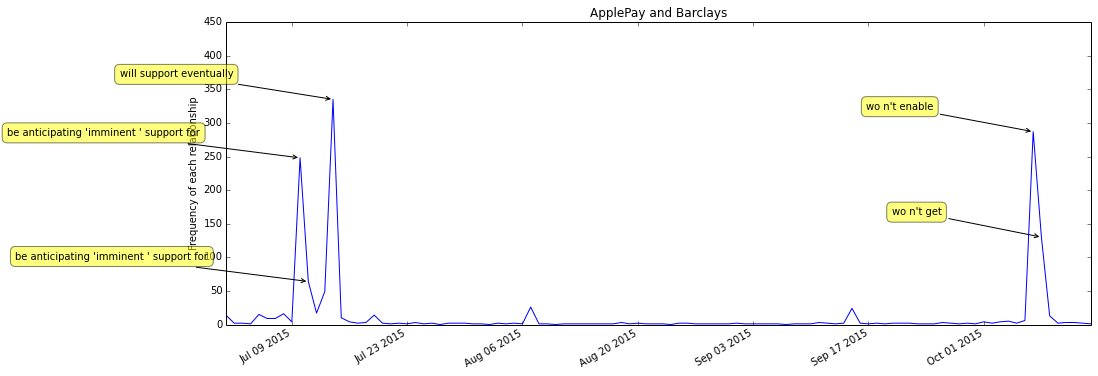

In [9]:
### FOR Starbucks
fig, ax = plt.subplots(figsize=(15.5, 6), facecolor='white', edgecolor='white')
#fig = plt.figure()
plt.plot(time_span, freq_trend)
plt.gcf().autofmt_xdate()
plt.title(ent1Name+" and "+ent2Name)
plt.ylabel('Frequency of each relationship')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2+100)) 

date = datetime(2015,10,1)

for label, x,y,s  in zip(rel_trend , time_span, freq_trend, sent_trend):
    #x > date and y > 10 or     
    thr = 50
    if y > thr :
        ax.annotate(
            label, 
            xy = (x, y), xytext = (-100, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))  
'''
    if (y >5 and x > datetime(2015,9,16)):
        ax.annotate(
            label, 
            xy = (x, y), xytext = (0, -120),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'), rotation =90)
'''            

In [ ]:
time_span[len(time_span)-1]

In [ ]:
print rel_sent_trend

In [ ]:
df_test = df[df.ollie_rel.str.contains("get")]

In [ ]:
print df_test.main_tweet.iloc[0]

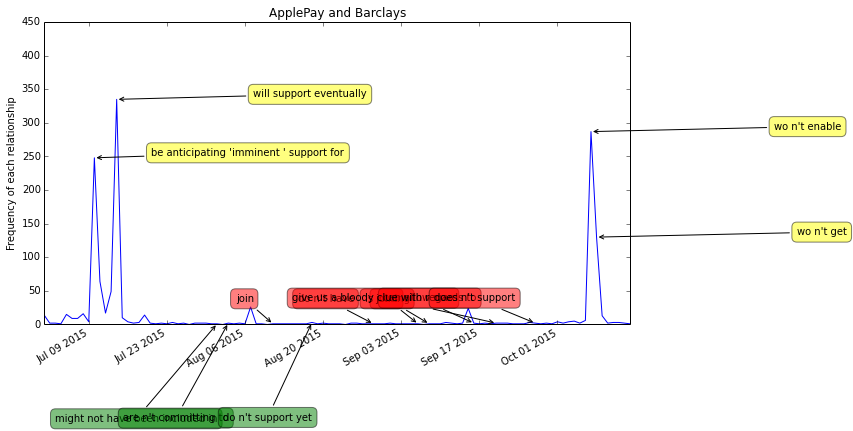

In [10]:
fig, ax = plt.subplots(figsize=(10.5, 6), facecolor='white', edgecolor='white')
#fig = plt.figure()
plt.plot(time_span, freq_trend)
plt.gcf().autofmt_xdate()
plt.title(ent1Name+" and "+ent2Name)
plt.ylabel('Frequency of each relationship')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2+100)) 

date = datetime(2015,10,1)

for label, x,y,s in zip(rel_trend , time_span, freq_trend, sent_trend):
    if y > 80 : #Barclays_ApplePay
    #if y > 5 :                
        ax.annotate(
            label, 
            xy = (x, y), xytext = (250, 0),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    elif s < -0.5:
    #if x > date and y > 10 or s < -0.5:
        ax.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'red', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))    
    
    elif s > 0.5:
    #if x > date and y > 10 or s < -0.5:
        ax.annotate(
            label, 
            xy = (x, y), xytext = (0, -100),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'green', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))    